# Quick introduction

## Reading and plotting

In [1]:
import io
import requests
from pathlib import Path


def download_demo_file(url):
    if not Path("CTD-spiked-unfiltered.cnv.bz2").exists():
        response = requests.get(url, allow_redirects=True)
        try:
            response.raise_for_status()
        except requests.exceptions.HTTPError as err:
            raise requests.exceptions.HTTPError(f"{response.content.decode()}") from err
        data = io.BytesIO(response.content)
        data.seek(0)
        Path("CTD-spiked-unfiltered.cnv.bz2").write_bytes(data.read())


url = "https://github.com/pyoceans/python-ctd/raw/main/tests/data/CTD-spiked-unfiltered.cnv.bz2"
download_demo_file(url)

In [2]:
import ctd


cast = ctd.from_cnv("CTD-spiked-unfiltered.cnv.bz2")
down, up = cast.split()

down.head()

,scan,timeS,t090C,t190C,c0S/m,c1S/m,sbeox0V,par,spar,ph,...,longitude,pumps,pla,sbeox0PS,sbeox0Mm/Kg,dz/dtM,accM,flSP,xmiss,flag
Pressure [dbar],,,,,,,,,,,,,,,,,,,,,
6.433,1.0,0.000,26.9647,26.9314,5.821803,5.800920,2.1099,1.000000e-12,0.0000,8.575,...,-37.22588,False,26.970,69.61016,137.397,0.000,0.00,0.16484,99.2996,False
6.448,2.0,0.042,26.9644,26.9307,5.821615,5.800819,2.1148,1.000000e-12,1.9601,8.580,...,-37.22588,False,26.969,69.82216,137.817,0.351,8.43,0.16484,99.3260,False
6.433,3.0,0.083,26.9642,26.9301,5.821421,5.800727,2.1209,1.000000e-12,0.0000,8.575,...,-37.22588,False,26.969,70.08688,138.341,-0.351,-16.87,0.16606,99.3260,False
6.448,4.0,0.125,26.9639,26.9296,5.821264,5.800727,2.1270,1.000000e-12,0.0000,8.575,...,-37.22588,False,26.969,70.35184,138.865,0.351,16.86,0.16606,99.3260,False
6.433,5.0,0.167,26.9640,26.9291,5.821219,5.800634,2.1331,1.000000e-12,0.0000,8.575,...,-37.22588,False,26.969,70.61657,139.388,-0.351,-16.86,0.16606,99.3525,False


It is a `pandas.DataFrame` with all the pandas methods and properties.

In [3]:
type(cast)

pandas.core.frame.DataFrame

But with extras for pre-processing and plotting a ocean vertical profiles.

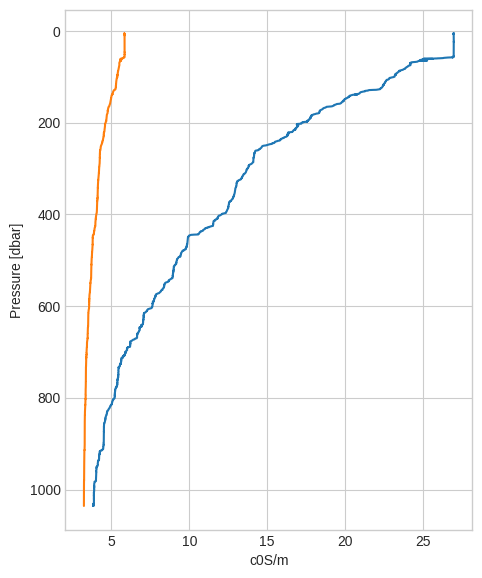

In [4]:
from matplotlib import style


style.use("seaborn-v0_8-whitegrid")

down["t090C"].plot_cast()
down["c0S/m"].plot_cast();

Sometimes it is useful to plot the second variable in a different axis so we can compare the two.

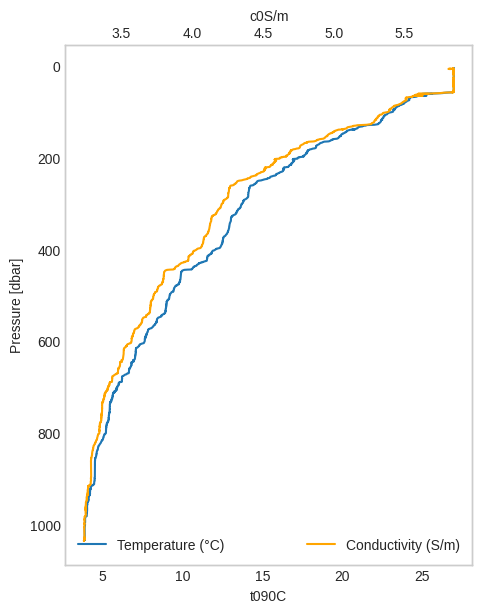

In [5]:
ax0 = down["t090C"].plot_cast(label="Temperature (°C)")
ax1 = down["c0S/m"].plot_cast(
    ax=ax0,
    label="Conductivity (S/m)",
    color="orange",
    secondary_y=True,
)


ax0.grid(False)
ax1.grid(False)

ax0.legend(loc="lower left")
ax1.legend(loc="lower right");

`python-ctd` saves of the file metadata in a dictionary to make them easy to access later. 

In [6]:
metadata = cast._metadata

metadata.keys()

dict_keys(['name', 'header', 'config', 'names', 'skiprows', 'time', 'lon', 'lat'])

In [7]:
print(metadata["header"])

* Sea-Bird SBE 9 Data File:
* FileName = Z:\CTD_1.hex
* Software Version Seasave V 7.21h
* Temperature SN = 2317
* Conductivity SN = 4010
* Number of Bytes Per Scan = 48
* Number of Voltage Words = 5
* Number of Scans Averaged by the Deck Unit = 1
* Append System Time to Every Scan
* System UpLoad Time = Apr 01 2011 07:26:31
* NMEA Latitude = 17 58.71 S
* NMEA Longitude = 037 13.52 W
* NMEA UTC (Time) = Apr 01 2011  07:26:31
* Store Lat/Lon Data = Append to Every Scan
** Ship: RV Meteor
** Station: 1
** Operator: Ed
* System UTC = Apr 01 2011 07:26:31
*END*


## Pre-processing steps

Usually the first pre-processing step is to filter the high frequency jitter in the pressure sensor with a low pass filter, here is a zoom in the pressure data (the `pandas` index) demonstrating it:

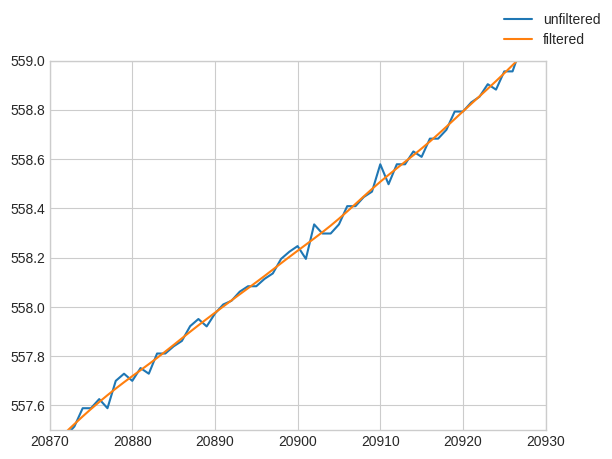

In [8]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()
ax.plot(down.index, label="unfiltered")
ax.plot(down.lp_filter().index, label="filtered")
ax.axis([20870, 20930, 557.5, 559])
fig.legend();

Thanks to [pandas_flavor](https://github.com/Zsailer/pandas_flavor) we can chain all the pre-processing steps together.

In [9]:
down = down[["t090C", "c0S/m"]]

proc = (
    down.remove_above_water()
    .remove_up_to(idx=7)
    .despike(n1=2, n2=20, block=100)
    .lp_filter()
    .press_check()
    .interpolate()
    .bindata(delta=1, method="interpolate")
    .smooth(window_len=21, window="hanning")
)

proc.head()

,t090C,c0S/m
8.0,26.975256,5.845194
9.0,26.975653,5.845291
10.0,26.976037,5.845386
11.0,26.976401,5.845478
12.0,26.976740,5.845565


## CTD derive

Now we can compute all the derived variables.

In [10]:
lon, lat = metadata["lon"], metadata["lat"]
lon, lat

(-37.22533333333333, -17.9785)

In [11]:
import gsw


p = proc.index

SP = gsw.SP_from_C(proc["c0S/m"].to_numpy() * 10.0, proc["t090C"].to_numpy(), p)
SA = gsw.SA_from_SP(SP, p, lon, lat)
SR = gsw.SR_from_SP(SP)

CT = gsw.CT_from_t(SA, proc["t090C"].to_numpy(), p)
z = -gsw.z_from_p(p, lat)
sigma0_CT = gsw.sigma0(SA, CT)

proc = (
    proc.assign(SP=SP)
    .assign(SA=SA)
    .assign(SR=SR)
    .assign(CT=CT)
    .assign(z=z)
    .assign(sigma0_CT=sigma0_CT)
)

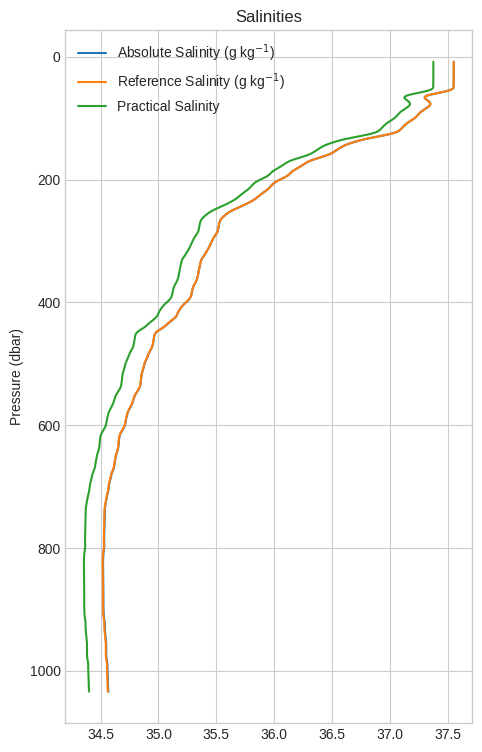

In [12]:
labels = [
    r"Absolute Salinity (g kg$^{-1}$)",
    r"Reference Salinity (g kg$^{-1}$)",
    "Practical Salinity",
]


ax = proc[["SA", "SR", "SP"]].plot_cast(
    figsize=(5.25, 9),
    label=labels,
)
ax.set_ylabel("Pressure (dbar)")
ax.grid(True)
ax.legend()
ax.set_title("Salinities");

Last but not least let's tweak a three line plot with the main variables measured.

In [13]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

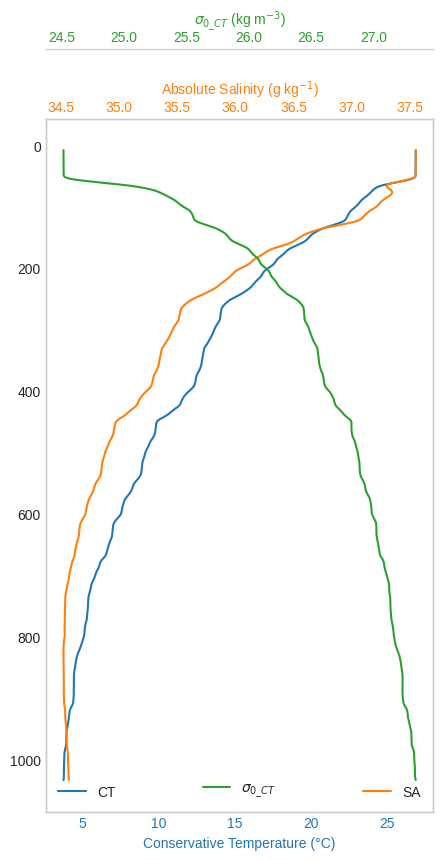

In [14]:
fig, ax0 = plt.subplots(figsize=(5, 9))

colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

ax0.invert_yaxis()
ax1 = ax0.twiny()
ax2 = ax0.twiny()

(l0,) = ax0.plot(proc["CT"], proc.index, color=colors[0], label="CT")
ax0.set_xlabel("Conservative Temperature (°C)")

(l1,) = ax1.plot(proc["SA"], proc.index, color=colors[1], label="SA")
ax1.set_xlabel("Absolute Salinity (g kg$^{-1}$)")

(l2,) = ax2.plot(
    proc["sigma0_CT"], proc.index, color=colors[2], label=r"$\sigma_{0\_CT}$"
)
ax2.set_xlabel(r"$\sigma_{0\_CT}$ (kg m$^{-3}$)")

make_patch_spines_invisible(ax2)
ax2.spines["top"].set_position(("axes", 1.1))
ax2.spines["top"].set_visible(True)

ax0.xaxis.label.set_color(l0.get_color())
ax1.xaxis.label.set_color(l1.get_color())
ax2.xaxis.label.set_color(l2.get_color())

ax0.tick_params(axis="x", colors=l0.get_color())
ax1.tick_params(axis="x", colors=l1.get_color())
ax2.tick_params(axis="x", colors=l2.get_color())

ax0.grid(False)
ax1.grid(False)
ax2.grid(False)

ax0.legend(loc="lower left")
ax1.legend(loc="lower right")
ax2.legend(loc="lower center");